**Sales Predictions**

*Import the Data*

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn import set_config
set_config(display="diagram")
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor

In [3]:
csv = "/content/sales_predictions.csv"
#"df" is used for data analysis
df = pd.read_csv(csv)
#"pred_sales_df" is used for predicting sales via machine learning 
pred_sales_df = pd.read_csv(csv)
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


*Data Exploration*

Determine the amount of rows and columns respectively.

In [4]:
df.shape

(8523, 12)

Checking the types of data assigned per column. 

In [5]:
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

Checking for duplicate rows in the data.

In [6]:
df.duplicated().sum()

0

From analyzing the data, it can be determined the Item_Identifier column is unnecessary and will cause errors in the predictions for sales. The best action to take would be to drop the column using the "df" and "pred_sales_df" dataset.

In [7]:
df.drop(columns="Item_Identifier")
pred_sales_df.drop(columns="Item_Identifier")

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...
8518,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834
8519,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,NaN,Tier 2,Supermarket Type1,549.2850
8520,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136
8521,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.5976


Checking for missing values in the data.

In [8]:
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

Determine what values are assigned to the column "Outlet_Size". Using this information, the best practice for the missing data can be applied.

In [9]:
df["Outlet_Size"].value_counts()

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

Assign Medium values for missing data to keep all data together and available for analysis. Dropping the missing data would lose too much information.

In [10]:
df["Outlet_Size"].fillna("Medium", inplace=True)
df["Outlet_Size"].value_counts()

Medium    5203
Small     2388
High       932
Name: Outlet_Size, dtype: int64

Determine what values are assigned to the column "Item_Weight".

In [11]:
df[df["Item_Weight"].isna()].describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,0.0,1463.000000,1463.000000,1463.0,1463.000000
mean,NaN,0.076597,139.796485,1985.0,2483.677474
std,NaN,0.063012,61.617672,0.0,2347.516621
min,NaN,0.000000,31.290000,1985.0,33.955800
25%,NaN,0.029545,92.630400,1985.0,399.480000
50%,NaN,0.060588,143.781200,1985.0,1845.597600
75%,NaN,0.110718,184.426600,1985.0,3968.168000
max,NaN,0.328391,266.588400,1985.0,13086.964800


Filling in the missing data with the median value would prevent losing data and can provide consistency.

In [12]:
df["Item_Weight"].fillna(df["Item_Weight"].median(), inplace=True)
df.isna().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

Checking for Inconsistent Categories in the data for columns with object data types.

In [13]:
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [14]:
categories = ["Item_Fat_Content", "Item_Type", "Outlet_Identifier", "Outlet_Size",
              "Outlet_Location_Type", "Outlet_Type"]
for values in categories:
  print("\n", values)
  print(df[values].value_counts())


 Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

 Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

 Outlet_Identifier
OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    528
Name: Outlet_Identifier, dtype: int64

 Outlet_Size
Medium    5203
Small     2388
High       932
Name: Outlet_Size, dtype: int64

 Outlet_Location_Type
Tier 3    3350
Tier 2    2785


As we can see, "Item_Fat_Content" contains inconsistent categories. Low Fat and Regular should be the only two values in this column.

In [15]:
df["Item_Fat_Content"].replace({"LF":"Low Fat","reg":"Regular","low fat":"Low Fat"}, inplace=True)
pred_sales_df["Item_Fat_Content"].replace({"LF":"Low Fat","reg":"Regular","low fat":"Low Fat"}, inplace=True)
df["Item_Fat_Content"].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

**Data Visualization**

*Histogram of Item Type*

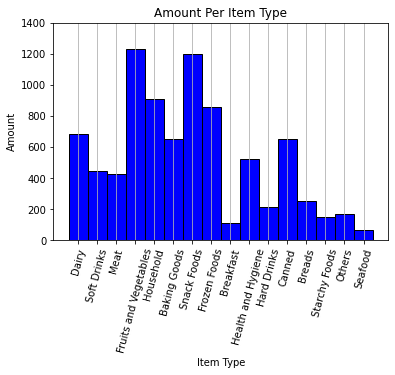

In [16]:
plt.hist(df["Item_Type"], bins=np.arange(17)-0.5, color="blue", ec="black");
plt.ylim(bottom=0, top=1400);
plt.ylabel("Amount");
plt.xlabel("Item Type");
plt.xticks(rotation=75);
plt.title("Amount Per Item Type");
plt.grid(axis="x");
plt.savefig('ItemTypeAmount.png', bbox_inches = "tight")

*Boxplot of Item Visibility per Item Fat Content*

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


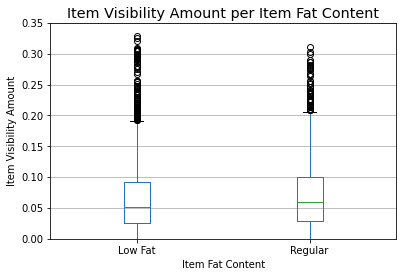

In [17]:
df.boxplot(column="Item_Visibility", by="Item_Fat_Content")
plt.style.use("classic")
plt.ylim(bottom=0, top=0.35)
plt.ylabel("Item Visibility Amount")
plt.xlabel("Item Fat Content")
plt.title("Item Visibility Amount per Item Fat Content")
plt.suptitle("")
plt.grid(axis="x")
plt.savefig('ItemVisPerFatContent.png', bbox_inches = "tight")

*Correlation in Data*

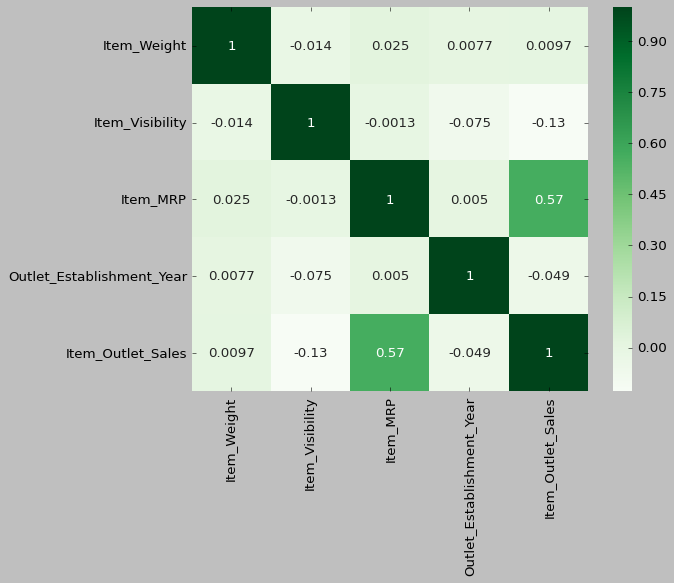

In [18]:
sns.heatmap(df.corr(), cmap ="Greens", annot=True);
plt.savefig('Correlation.png', bbox_inches = "tight")

From the correlation table, we can determine there is little correlation between most of the columns provided. The best correlation between two different columns of data would be Item_Outlet_Sales and Item_MRP.

**Prediction using Machine Learning**

Confirm there are no missing data

In [19]:
pred_sales_df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

Identify the features (X) and target (y), wherethe "Item_Outlet_Sales" column is the target and the rest of the relevant variables as your features matrix.

In [20]:
target = "Item_Outlet_Sales"
X = pred_sales_df.drop(columns=target)
y = pred_sales_df[target]

Perform a train test split of the data.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Instantiate Transformers: create preprocessing objects to prepare the dataset for Machine Learning.

In [22]:
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False, handle_unknown="ignore")

mean_imputer = SimpleImputer(strategy="mean")
freq_imputer = SimpleImputer(strategy="most_frequent")

Create Pipeline for Numerical and Categorical Data. 

In [23]:
num_pipeline = make_pipeline(mean_imputer, scaler)
nom_pipeline = make_pipeline(freq_imputer, ohe)

Create Tuples to pair Pipelines with Selected Columns.

In [24]:
cat_selector = make_column_selector(dtype_include="object")
num_selector = make_column_selector(dtype_include="number")
num_tuple = (num_pipeline, num_selector)
nom_tuple = (nom_pipeline, cat_selector)

Instantiate the Column Transformer.

In [25]:
preprocessor = make_column_transformer(nom_tuple,
                                       num_tuple,
                                       remainder="passthrough")

Fit the Column Transformer on training data.

In [26]:
preprocessor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f8066867a90>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f80668679d0>)])

Transform the training data and testing data, then check the results in a numpy array.

In [27]:
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)
X_train_transformed

array([[ 0.        ,  0.        ,  0.        , ..., -0.71277507,
         1.82810922,  1.32784893],
       [ 0.        ,  0.        ,  0.        , ..., -1.29105225,
         0.60336888,  1.32784893],
       [ 0.        ,  0.        ,  0.        , ...,  1.81331864,
         0.24454056,  0.13618724],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -0.92052713,
         1.52302674,  0.49368575],
       [ 0.        ,  0.        ,  0.        , ..., -0.2277552 ,
        -0.38377708,  1.0895166 ],
       [ 0.        ,  0.        ,  0.        , ..., -0.95867683,
        -0.73836105, -0.10214509]])

**Linear Regression Model**

Create Linear Regression model to visualize the data with an error term and a regression line displaying the best outcome to minimize the error.

In [28]:
reg = LinearRegression()

reg_pipe = make_pipeline(preprocessor, reg)
reg_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f8066867a90>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f80668679d0>)])),
                ('linearregression', LinearRegression())])

Compare predictions with original values.

In [29]:
reg_pred = reg_pipe.predict(X_test)
reg_pred_df = X_test.copy()
reg_pred_df['Item_Outlet_Sales'] = y_test
reg_pred_df['Predicted_Outlet_Sales'] = reg_pred
reg_pred_df['Error'] = reg_pred - y_test
reg_pred_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Predicted_Outlet_Sales,Error
7503,FDI28,14.300,Low Fat,0.026300,Frozen Foods,79.4302,OUT013,1987,High,Tier 3,Supermarket Type1,1743.0644,874.0,-869.0644
2957,NCM17,7.930,Low Fat,0.071136,Health and Hygiene,42.7086,OUT046,1997,Small,Tier 1,Supermarket Type1,356.8688,992.0,635.1312
7031,FDC14,14.500,Regular,0.041313,Canned,42.0454,OUT049,1999,Medium,Tier 1,Supermarket Type1,377.5086,1300.0,922.4914
1084,DRC36,NaN,Regular,0.044767,Soft Drinks,173.7054,OUT027,1985,Medium,Tier 3,Supermarket Type3,5778.4782,3728.0,-2050.4782
856,FDS27,10.195,Regular,0.012456,Meat,197.5110,OUT035,2004,Small,Tier 2,Supermarket Type1,2356.9320,1822.0,-534.9320


Evaluate performance based on R squared matrix

In [30]:
train_reg_pred = reg_pipe.predict(X_train)
test_reg_pred = reg_pipe.predict(X_test)
train_reg_r2 = r2_score(y_train, train_reg_pred)
test_reg_r2 = r2_score(y_test, test_reg_pred)

print(f"Linear Regression Training R2: {train_reg_r2}")
print(f"Linear Regression Testing R2: {test_reg_r2}")

Linear Regression Training R2: 0.6707557333710141
Linear Regression Testing R2: -8.369244553771011e+20


Evaluate performance based on Root Mean Squared Error matrix

In [31]:
train_reg_RMSE = np.sqrt(mean_squared_error(y_train, train_reg_pred))
test_reg_RMSE = np.sqrt(mean_squared_error(y_test, test_reg_pred))

print(f"Linear Regression Training RMSE: {train_reg_RMSE}")
print(f"Linear Regression Testing RMSE: {test_reg_RMSE}")

Linear Regression Training RMSE: 987.1088202715116
Linear Regression Testing RMSE: 48052633268067.38


**Regression Tree Model**

Create Decision Tree model to interpret the data easier and make faster predictions.

In [41]:
dec_tree = DecisionTreeRegressor(random_state=42)

tree_pipe = make_pipeline(preprocessor, dec_tree)
tree_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f8066867a90>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f80668679d0>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

Tune Regression Tree Model

In [36]:
dec_tree.get_depth()

60

In [42]:
max_depth_range = list(range(1, 60))
r2 = []
for depth in max_depth_range:
  dec_tree = DecisionTreeRegressor(max_depth= depth, random_state=42)
  tree_pipe = make_pipeline(preprocessor, dec_tree)
  tree_pipe.fit(X_train, y_train)
  score = tree_pipe.score(X_test, y_test)
  r2.append(score)

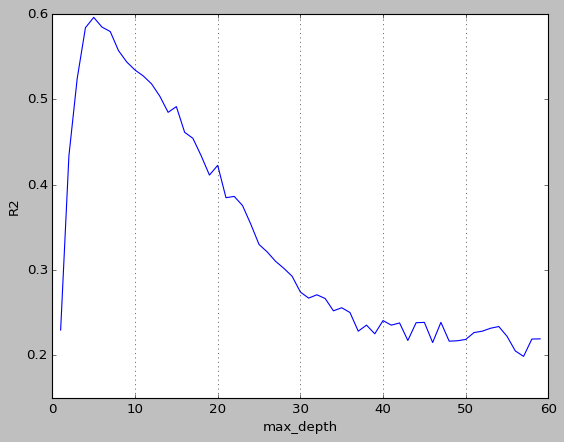

In [44]:
plt.plot(max_depth_range, r2)
plt.xlabel('max_depth')
plt.ylabel('R2')
plt.grid(axis="x");

From the graph above, I can conclude the max_depth for this Decision Tree should be 5.

Evaluate performance based on R squared matrix

In [46]:
dec_tree_5 = DecisionTreeRegressor(max_depth = 5, random_state=42)
tree_pipe_5 = make_pipeline(preprocessor, dec_tree_5)
tree_pipe_5.fit(X_train, y_train)
train_tree_pred = tree_pipe_5.predict(X_train)
test_tree_pred = tree_pipe_5.predict(X_test)
train_tree_r2 = r2_score(y_train, train_tree_pred)
test_tree_r2 = r2_score(y_test, test_tree_pred)

print(f"Regression Tree Training R2: {train_tree_r2}")
print(f"Regression Tree Testing R2: {test_tree_r2}")

Regression Tree Training R2: 0.6042066848171654
Regression Tree Testing R2: 0.5960564372160062


Evaluate performance based on Root Mean Squared Error matrix

In [47]:
train_tree_RMSE = np.sqrt(mean_squared_error(y_train, train_tree_pred))
test_tree_RMSE = np.sqrt(mean_squared_error(y_test, test_tree_pred))

print(f"Regression Tree Training RMSE: {train_tree_RMSE}")
print(f"Regression Tree Testing RMSE: {test_tree_RMSE}")

Regression Tree Training RMSE: 1082.281287111312
Regression Tree Testing RMSE: 1055.6851402178304


When comparing the two models above, I recommend implementing the Regression Tree model. From the metrics shown above, the R squared matrix in the model can account for about 60% of the variation in the test target using the features. Additionally, the Root Mean Squared Error matrix in the model shows a small margin of error in relation to the training data and testing data.